In [2]:
##### To DO: EDA #####
# 1. Check for missing values -> Done
# 2. Summary statistics -> Done 
# 3. Visualizations -> Done
# 4. Correlation analysis -> Done
# 5. Time series analysis -> Decomposition and Autocorrelation Done
# 6. Anomaly detection
# 7. Feature engineering -> Done

In [ ]:
## libraries
import os
from dotenv import load_dotenv
import psycopg2
import psycopg2.extras as extras
import pandas as pd

## visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

## utilities
import feature_extraction

import warnings
warnings.filterwarnings("ignore")


In [4]:
# load .env file
load_dotenv()

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "name": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD")
}

connection = psycopg2.connect(
            database=DB_CONFIG["name"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"]
        )

## Query data from the database
data = pd.read_sql("SELECT * FROM public.weather_data_0001", connection)

In [5]:
data.head()

,id,temperature,humidity,pressure,wind_speed,wind_direction,beaufort,direction_code,timestamp,lux,solar_radiation
0,1.0,27.09,71.31,997.33,0.0,24.0,0,1,2025-09-07 19:43:13.288523+00:00,0.19,0.0
1,1.0,27.07,71.21,997.39,0.0,347.7,0,15,2025-09-07 19:48:14.288204+00:00,0.13,0.0
2,1.0,27.05,71.43,997.50,0.4,323.4,1,14,2025-09-07 19:53:15.288207+00:00,0.19,0.0
3,1.0,27.01,72.22,997.51,0.0,338.7,0,15,2025-09-07 19:58:16.297926+00:00,0.19,0.0
4,1.0,27.01,72.10,997.51,0.0,341.6,0,15,2025-09-07 20:03:17.293114+00:00,0.19,0.0


In [6]:
data.isna().sum()

id                 0
temperature        0
humidity           0
pressure           0
wind_speed         0
wind_direction     0
beaufort           0
direction_code     0
timestamp          0
lux                0
solar_radiation    0
dtype: int64

In [7]:
data = feature_extraction.feature_engineering(data, drop_columns=["id"], resample_freq="H")
data = feature_extraction.add_meteo_features(data)
data = feature_extraction.add_advanced_features_with_lags(data)
data = feature_extraction.generate_features(data)

Dropped columns: ['id']


In [8]:
## 2-Summary statistics
summary_stats = data.describe()
print("Summary statistics:")
summary_stats.T

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
temperature,593.0,28.107910,3.608057,21.5225,25.487500,27.640833,31.020000,37.101667
humidity,593.0,47.683722,15.866941,20.9875,34.535000,45.270833,60.673077,82.232308
pressure,593.0,1000.303964,2.071916,995.1550,999.027500,1000.145000,1001.804167,1005.721667
wind_speed,593.0,0.406015,0.532394,0.0000,0.066667,0.223077,0.516667,3.258333
wind_direction,593.0,244.294493,57.814794,46.3000,206.875000,251.646154,288.366667,349.583333
...,...,...,...,...,...,...,...,...
lag_wind_speed_12h,581.0,0.406509,0.536682,0.0000,0.066667,0.223077,0.516667,3.258333
lag_wind_speed_24h,569.0,0.407075,0.541635,0.0000,0.061538,0.216667,0.516667,3.258333
lag_solar_radiation_1h,592.0,27.269788,32.170533,0.0000,0.000000,3.705000,54.953942,126.264167
lag_solar_radiation_12h,581.0,27.104956,32.019619,0.0000,0.000000,3.082500,54.846923,126.264167


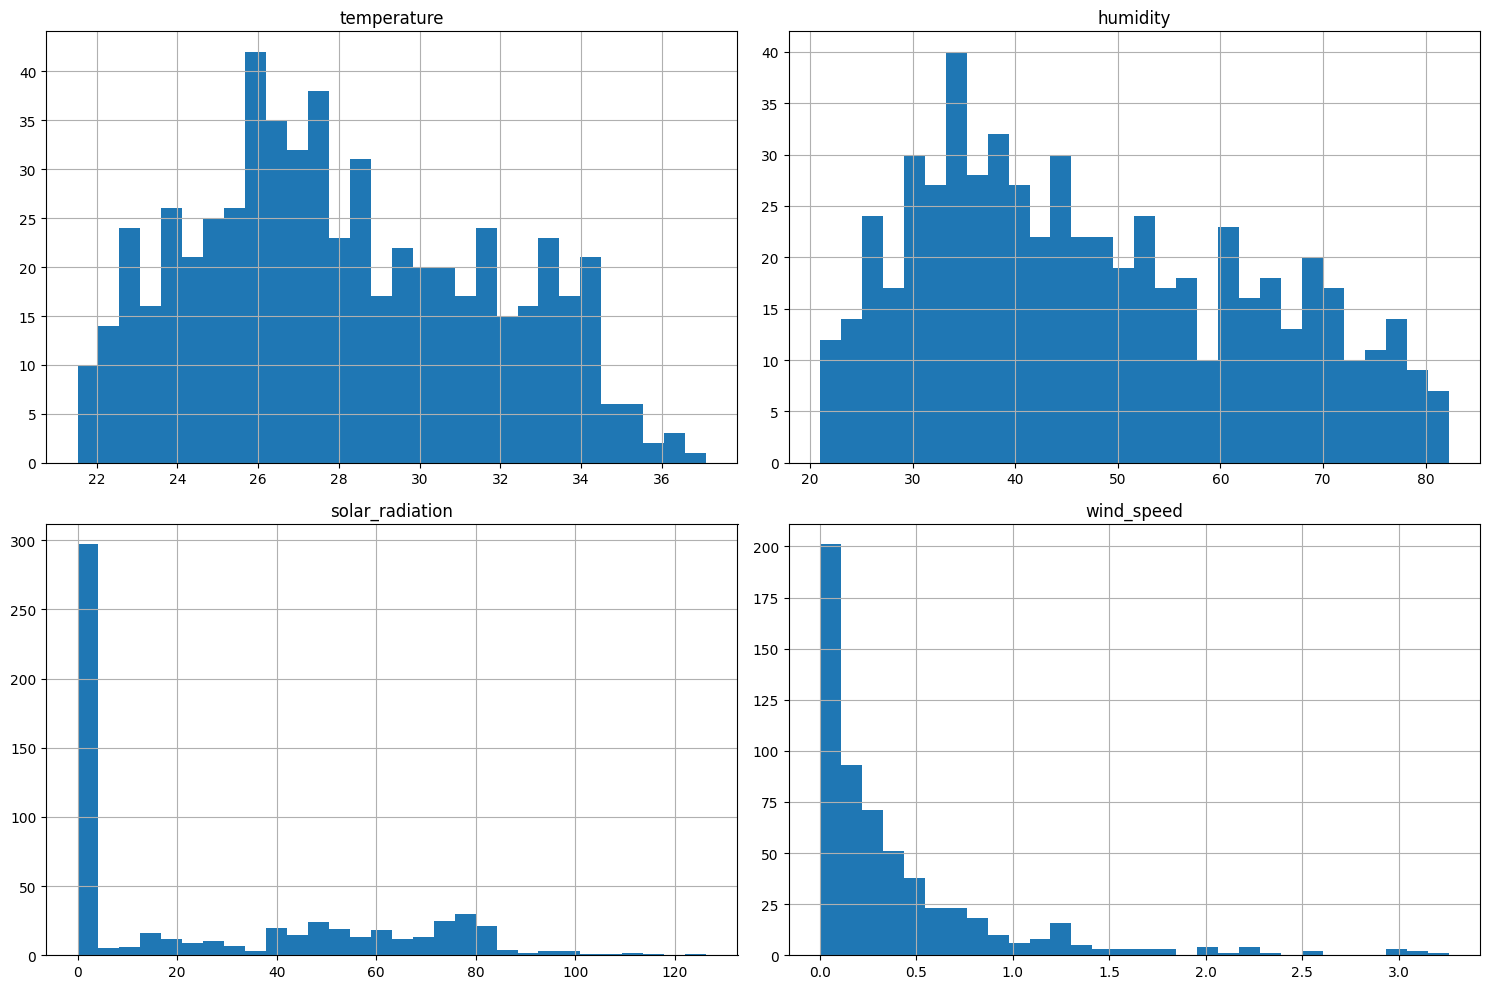

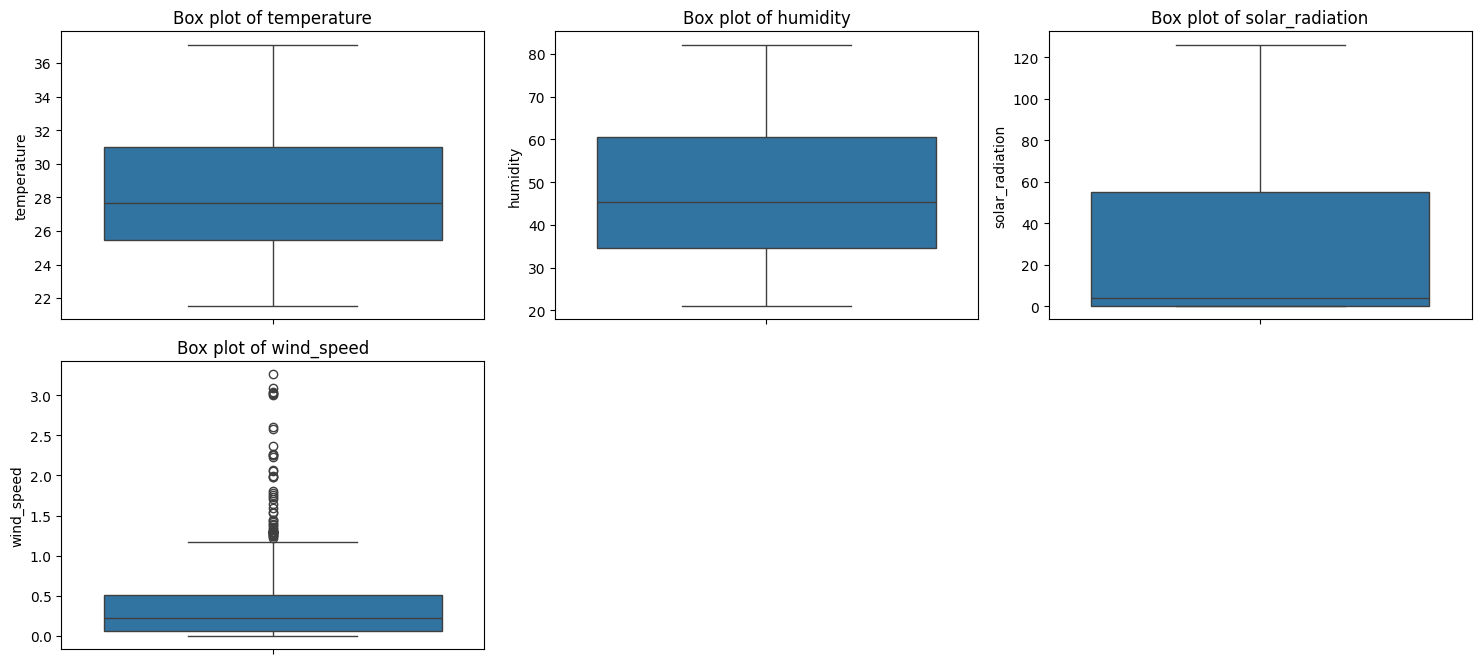

In [9]:
## 3-Visualizations

numerical_cols = data[["temperature","humidity","solar_radiation","wind_speed","lux"]].columns

# Multiple histograms
data[["temperature","humidity","solar_radiation","wind_speed"]].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()
# Box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(data[["temperature","humidity","solar_radiation","wind_speed"]].columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

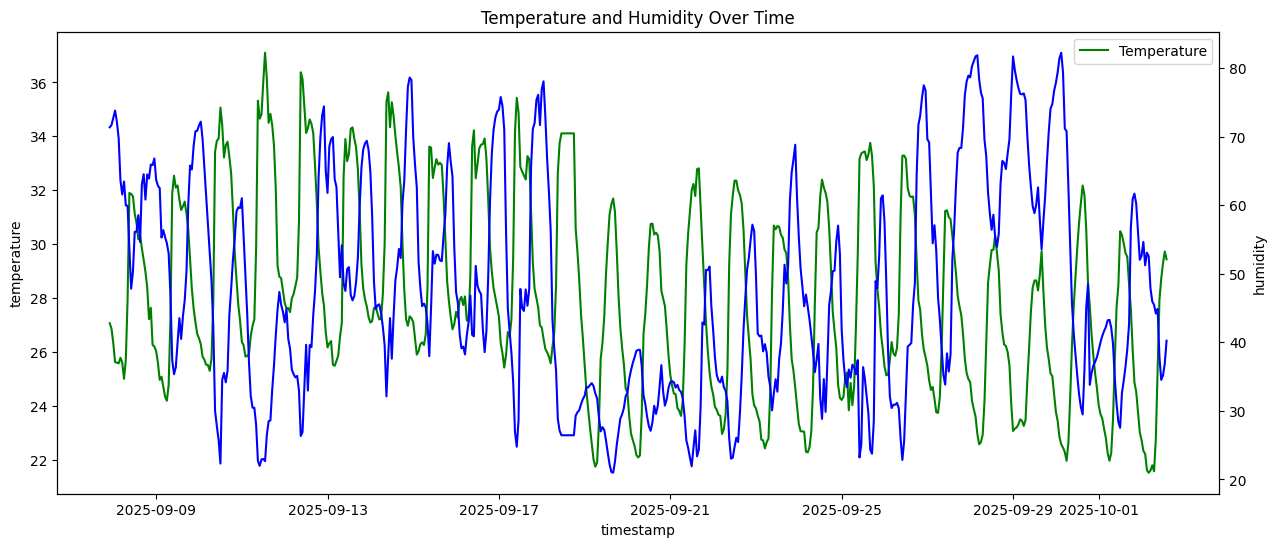

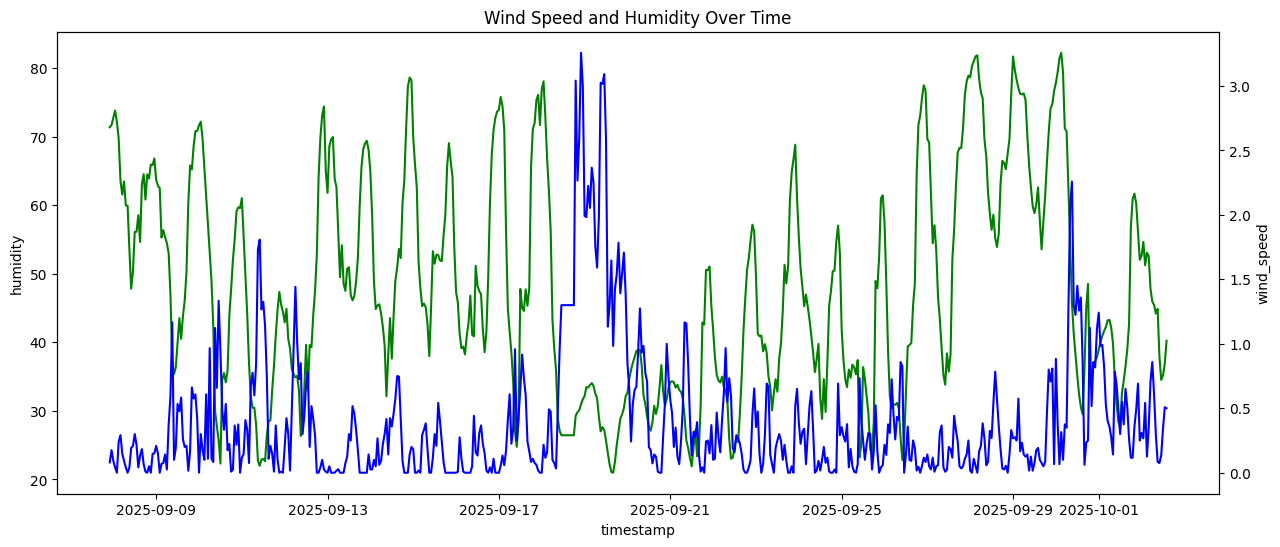

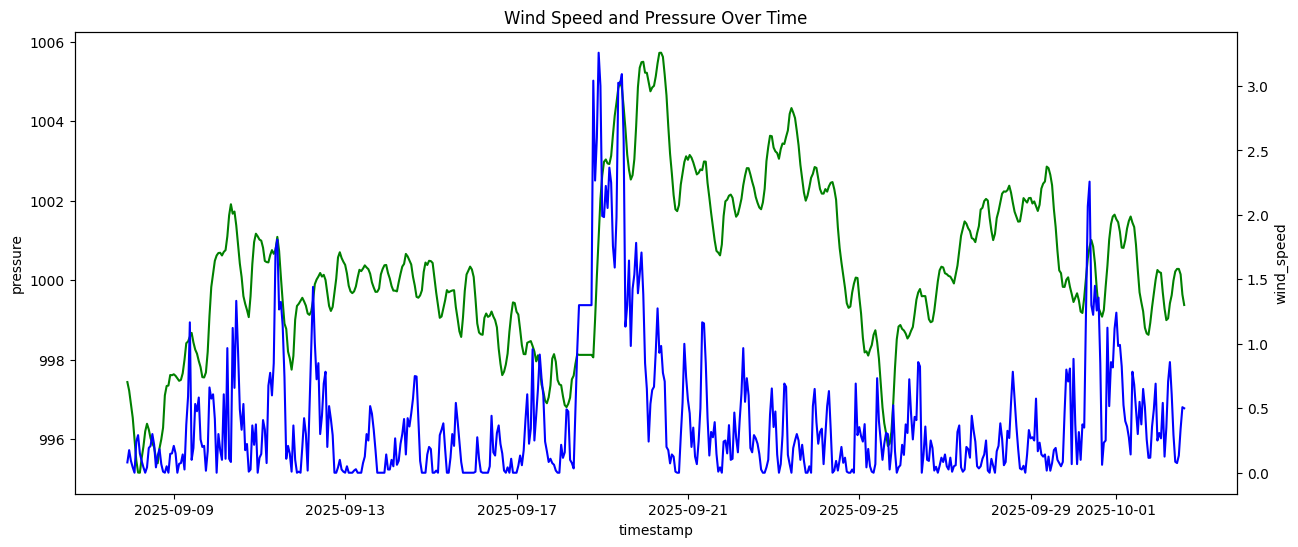

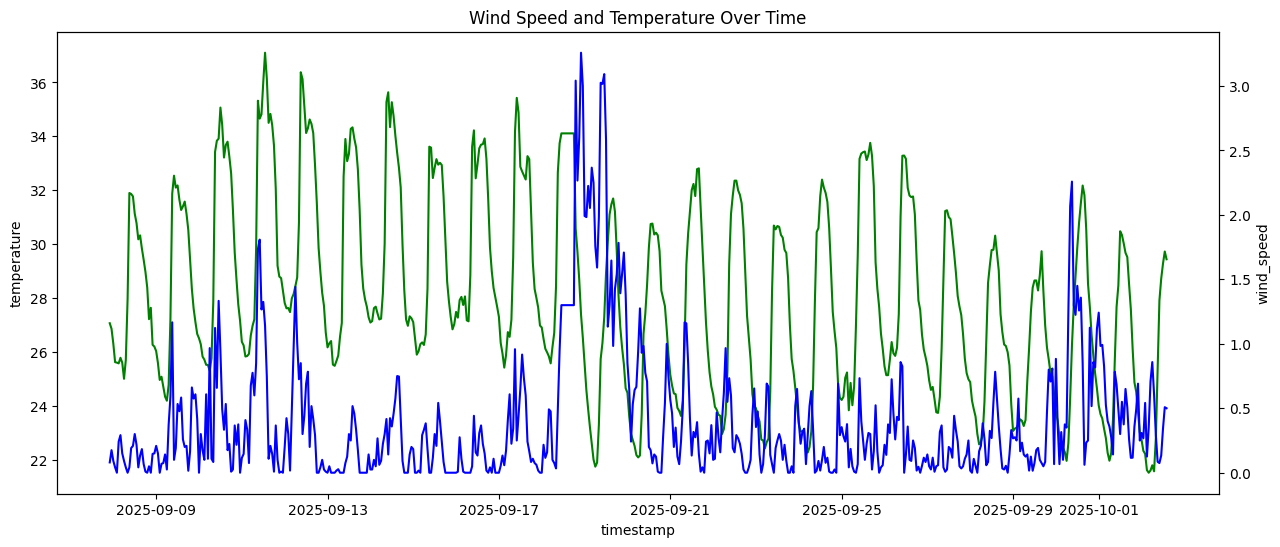

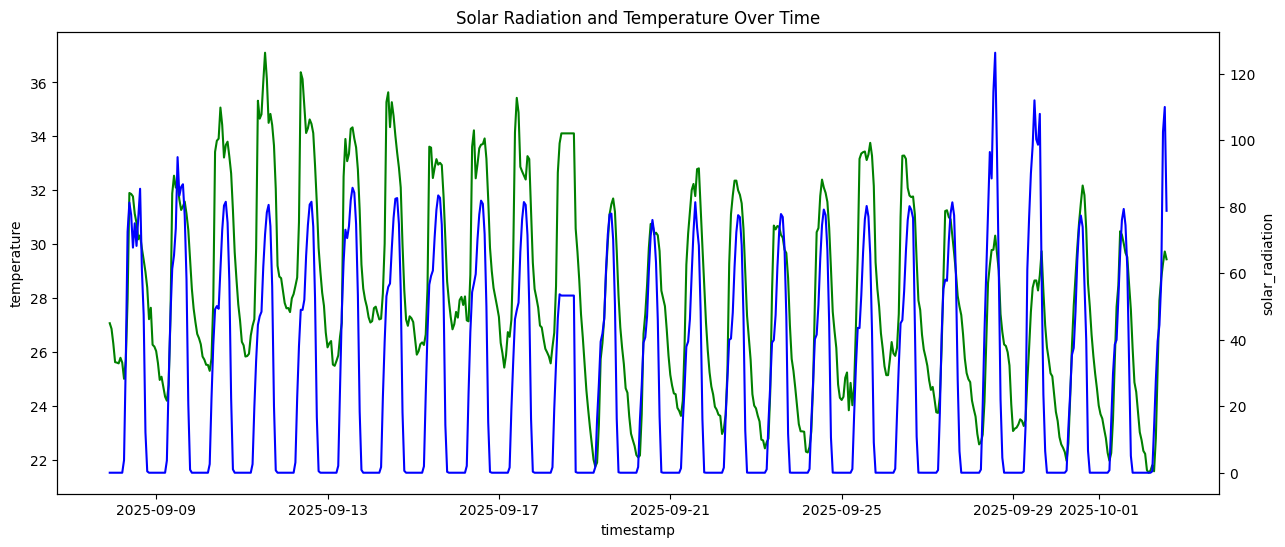

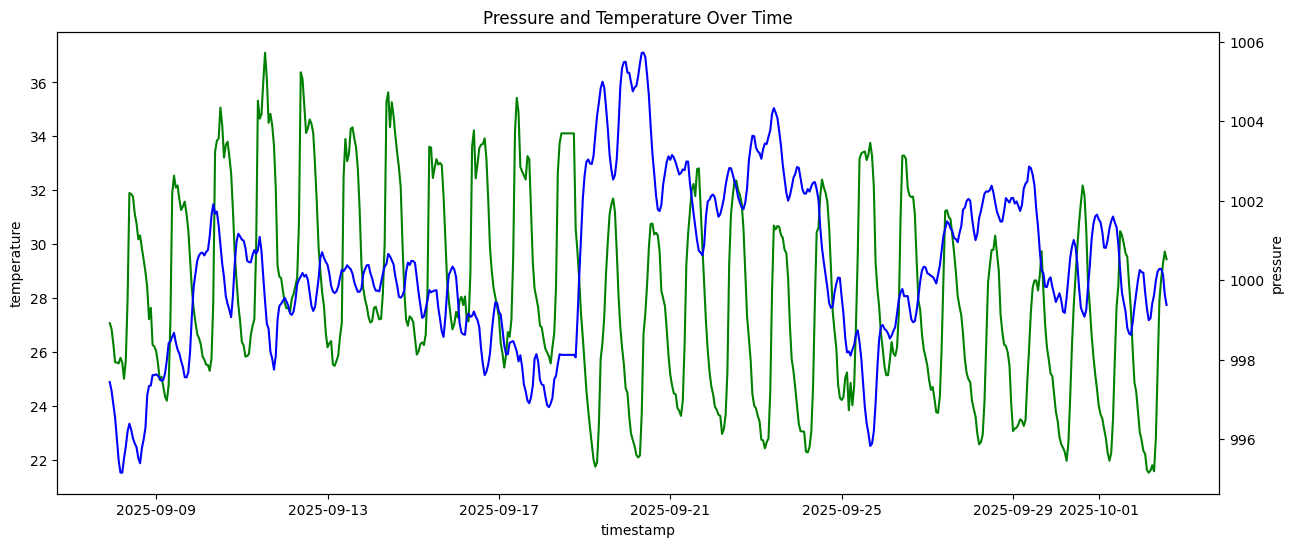

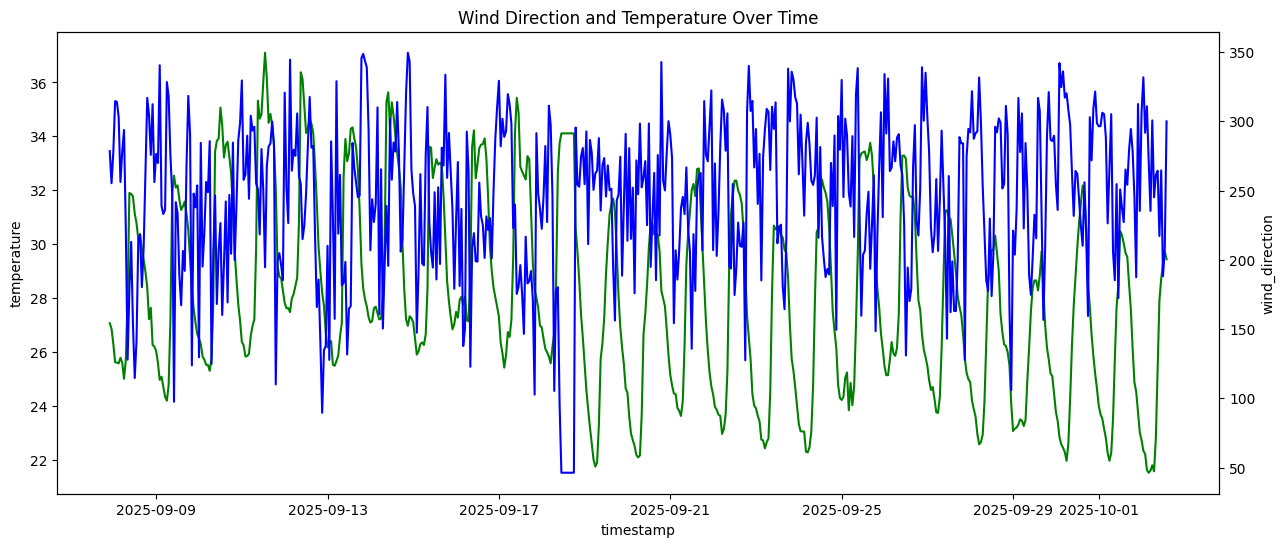

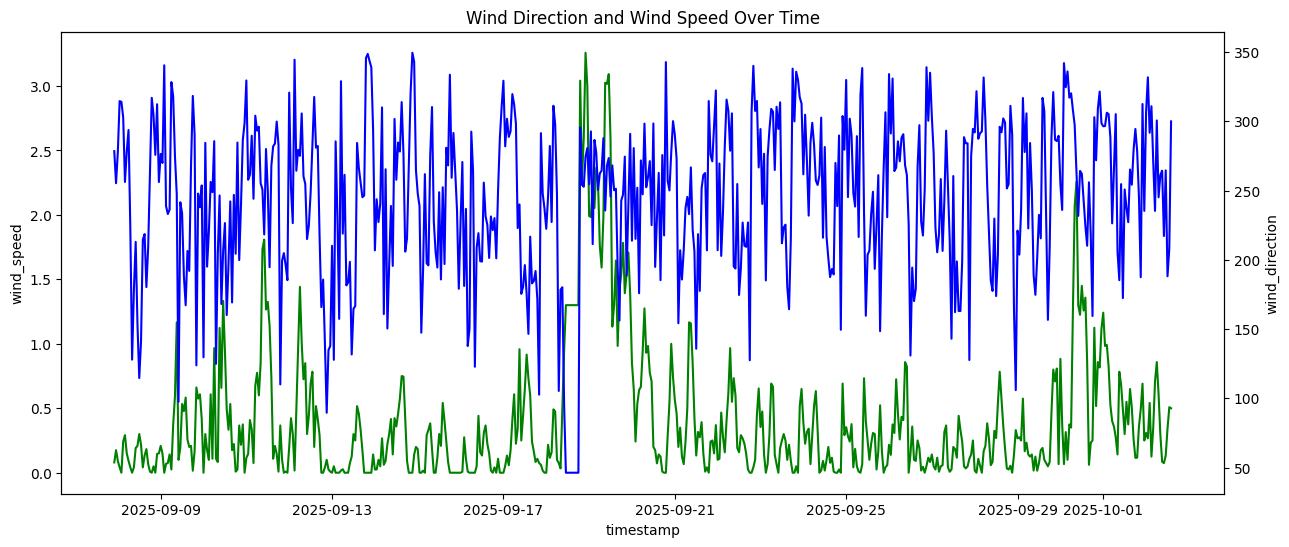

In [10]:
## Temporal trends two axis line plot
### Temperature and Humidity Over Time
plt.figure(figsize=(15, 6))
plt.title("Temperature and Humidity Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g",label = "Temperature")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="humidity", color="b", ax=ax2)
plt.show()

### Wind Speed and Precipitation Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Humidity Over Time")
sns.lineplot(data=data,x="timestamp",y="humidity",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()

### Wind Speed and Pressure Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Pressure Over Time")
sns.lineplot(data=data,x="timestamp",y="pressure",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()

### Temperature and Wind Speed Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()


### Temperature and Solar Radiation Over Time
plt.figure(figsize=(15, 6))
plt.title("Solar Radiation and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="solar_radiation", color="b", ax=ax2)
plt.show()


### Temperature and Pressure Over Time
plt.figure(figsize=(15, 6))
plt.title("Pressure and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="pressure", color="b", ax=ax2)
plt.show()

### Temperature and Wind Direction Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Direction and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction", color="b", ax=ax2)
plt.show()

### Wind Speed and Wind Direction Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Direction and Wind Speed Over Time")
sns.lineplot(data=data,x="timestamp",y="wind_speed",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction", color="b", ax=ax2)
plt.show()

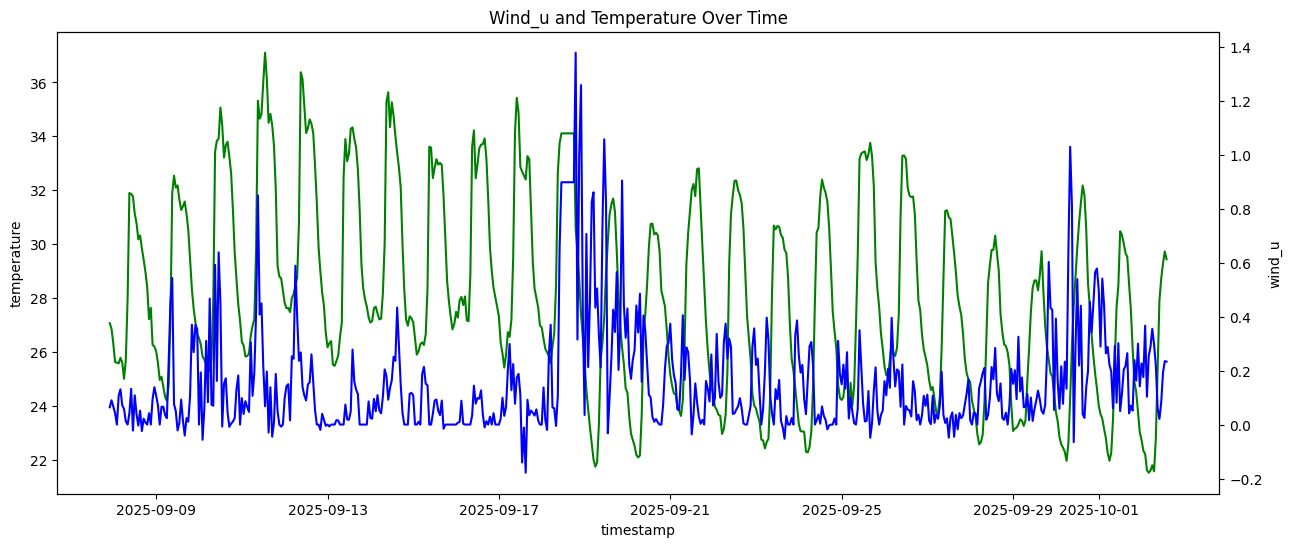

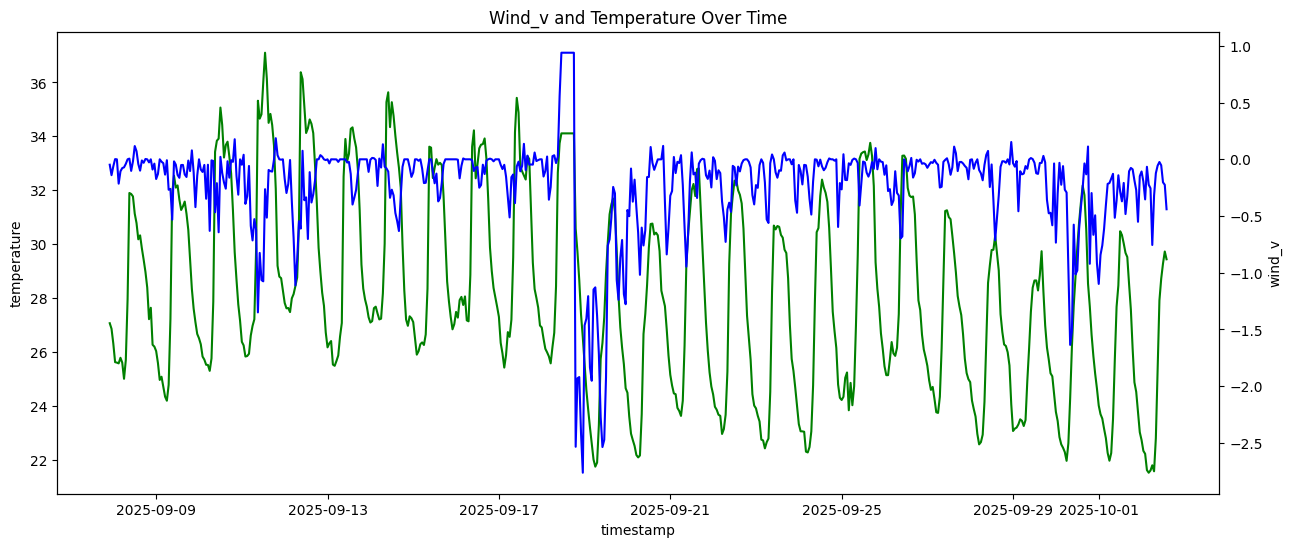

In [11]:
## temperature and wind_u
plt.figure(figsize=(15, 6))
plt.title("Wind_u and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_u", color="b", ax=ax2)
plt.show()


## temperature and wind_v
plt.figure(figsize=(15, 6))
plt.title("Wind_v and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_v", color="b", ax=ax2)
plt.show()

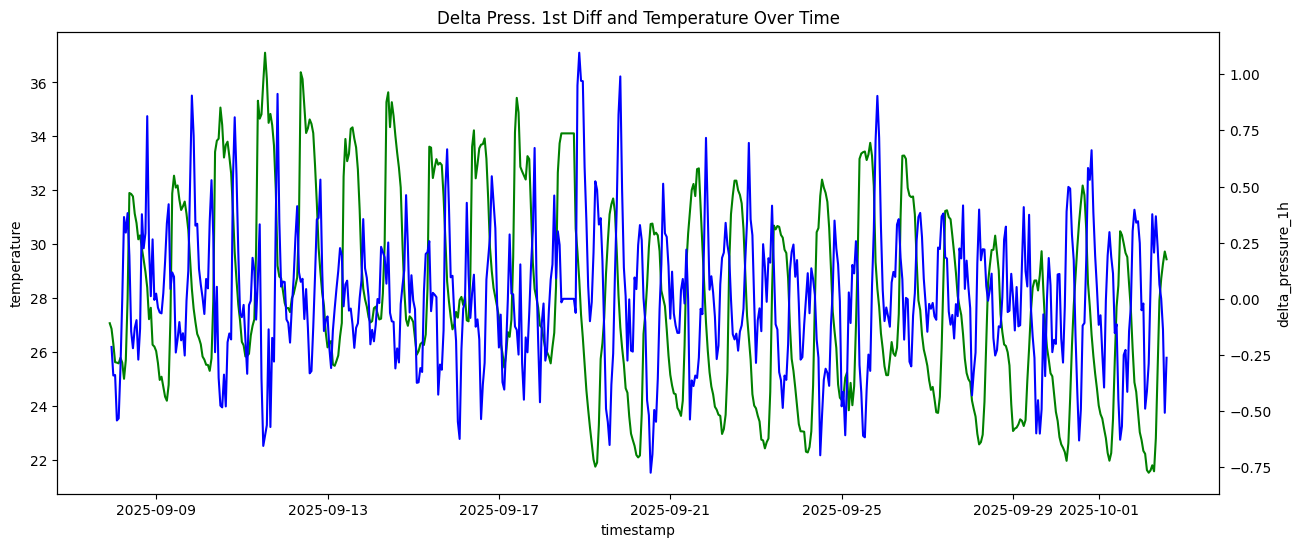

ValueError: Could not interpret value `delta_pressure_3h` for `y`. An entry with this name does not appear in `data`.

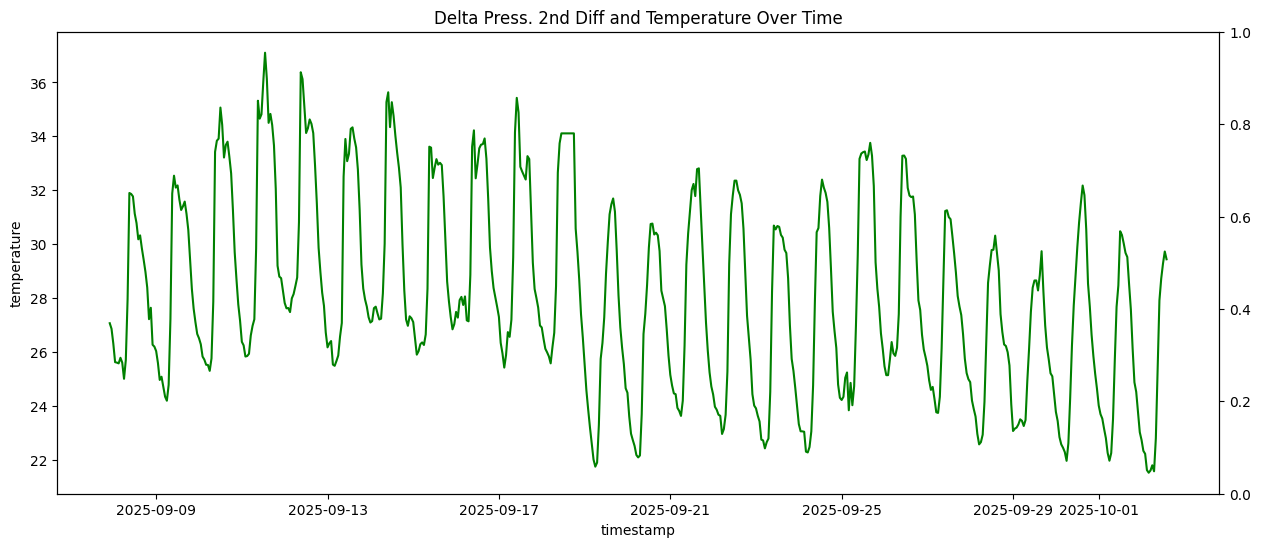

In [12]:
## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Delta Press. 1st Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_pressure_1h", color="b", ax=ax2)
plt.show()

## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Delta Press. 2nd Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_pressure_3h", color="b", ax=ax2)
plt.show()

## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Delta Press. 3rd Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_pressure_6h", color="b", ax=ax2)
plt.show()

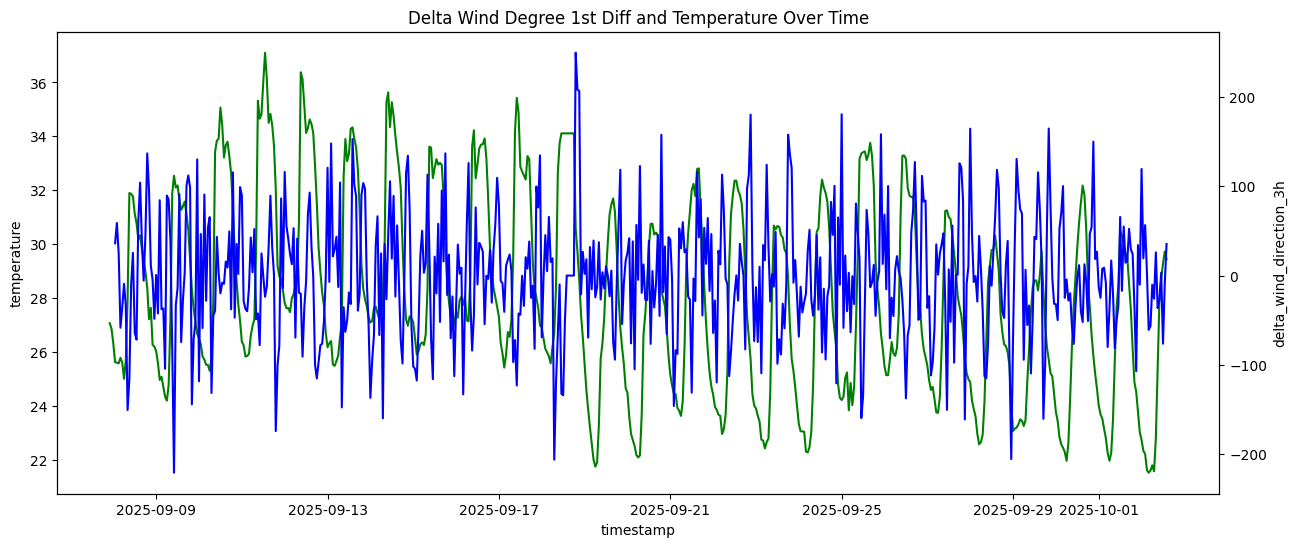

In [13]:
## temperature and wind degree delta
plt.figure(figsize=(15, 6))
plt.title("Delta Wind Degree 1st Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_wind_direction_3h", color="b", ax=ax2)
plt.show()

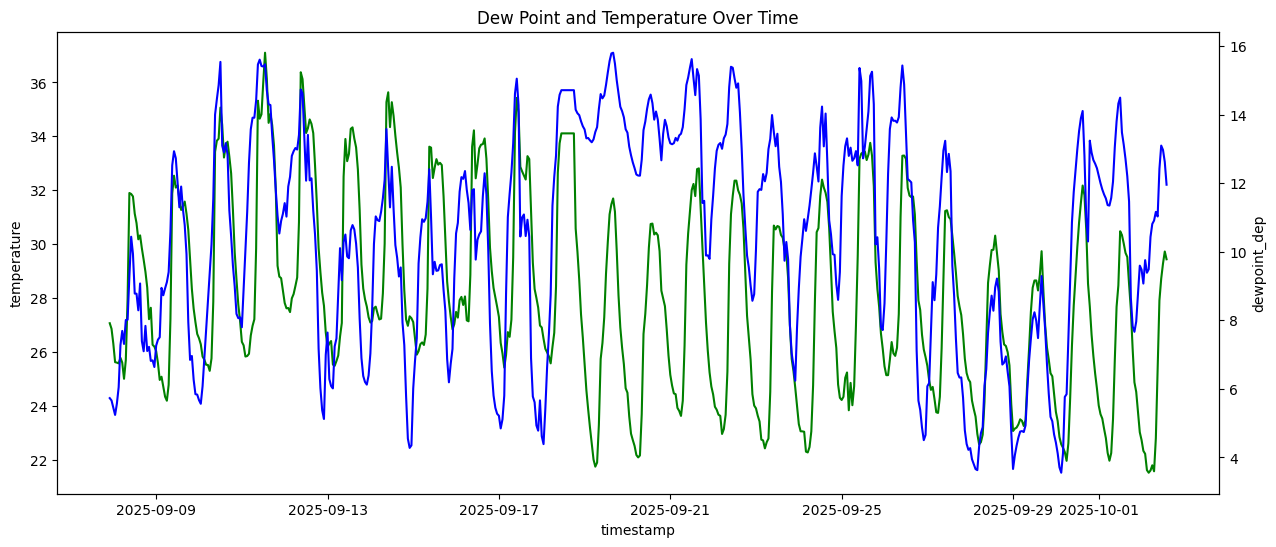

In [14]:
## temperature and dew point
plt.figure(figsize=(15, 6))
plt.title("Dew Point and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="dewpoint_dep", color="b", ax=ax2)
plt.show()

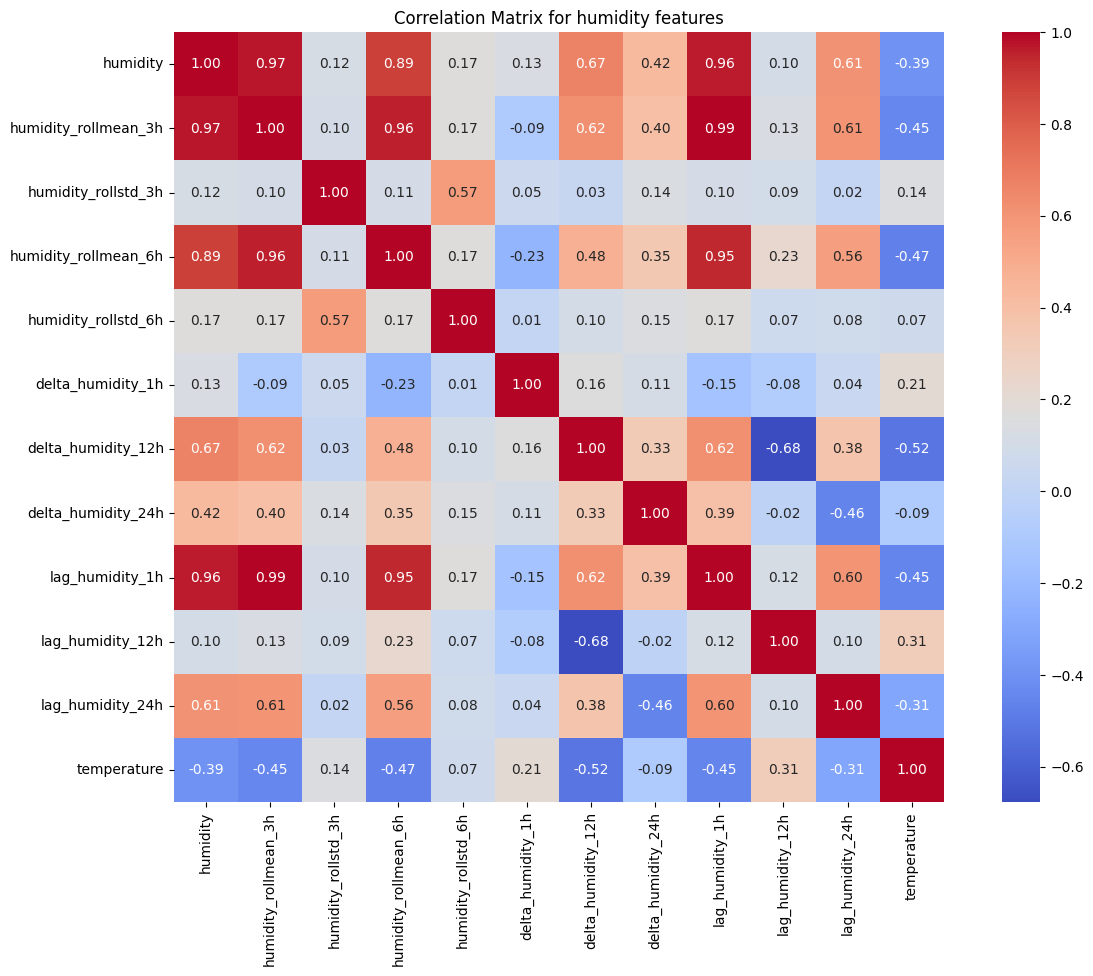

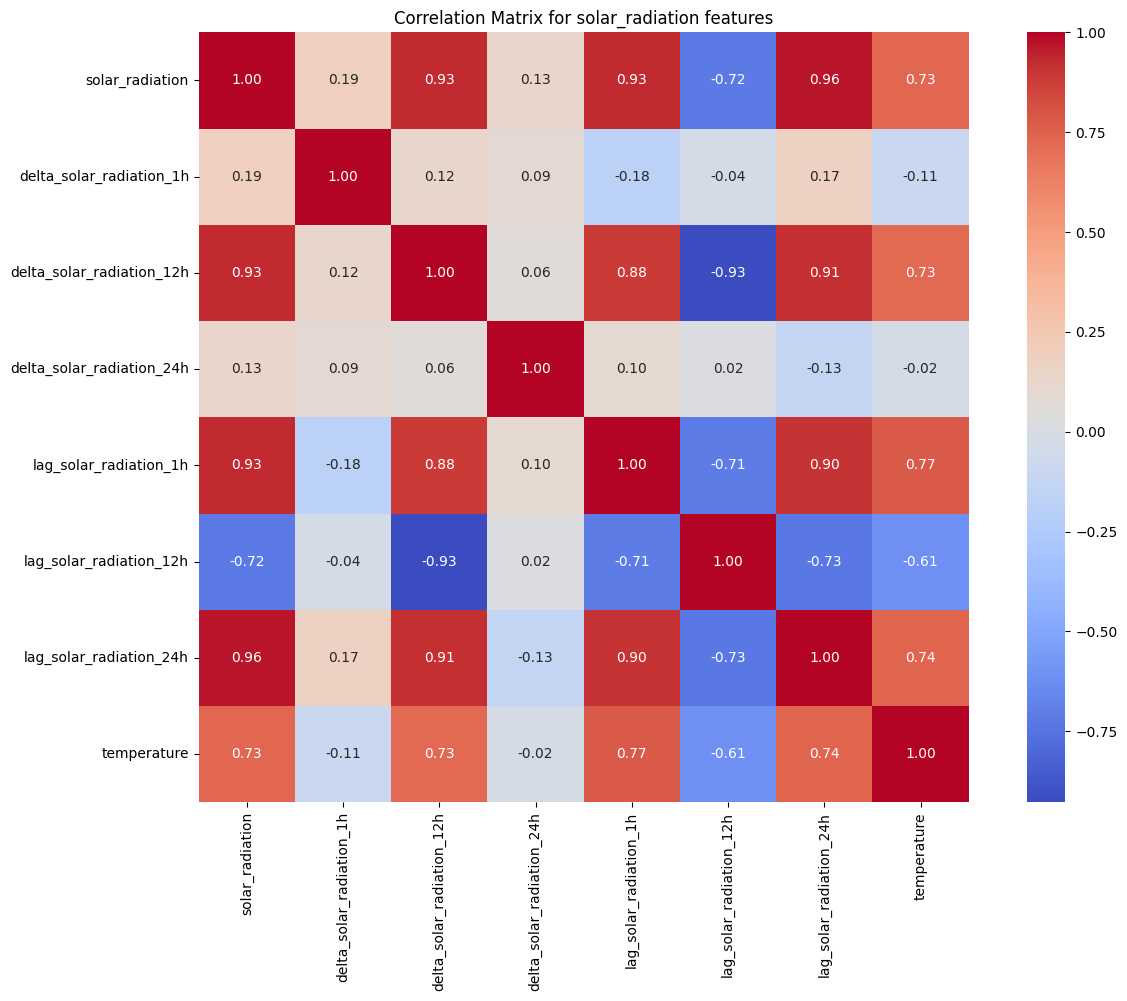

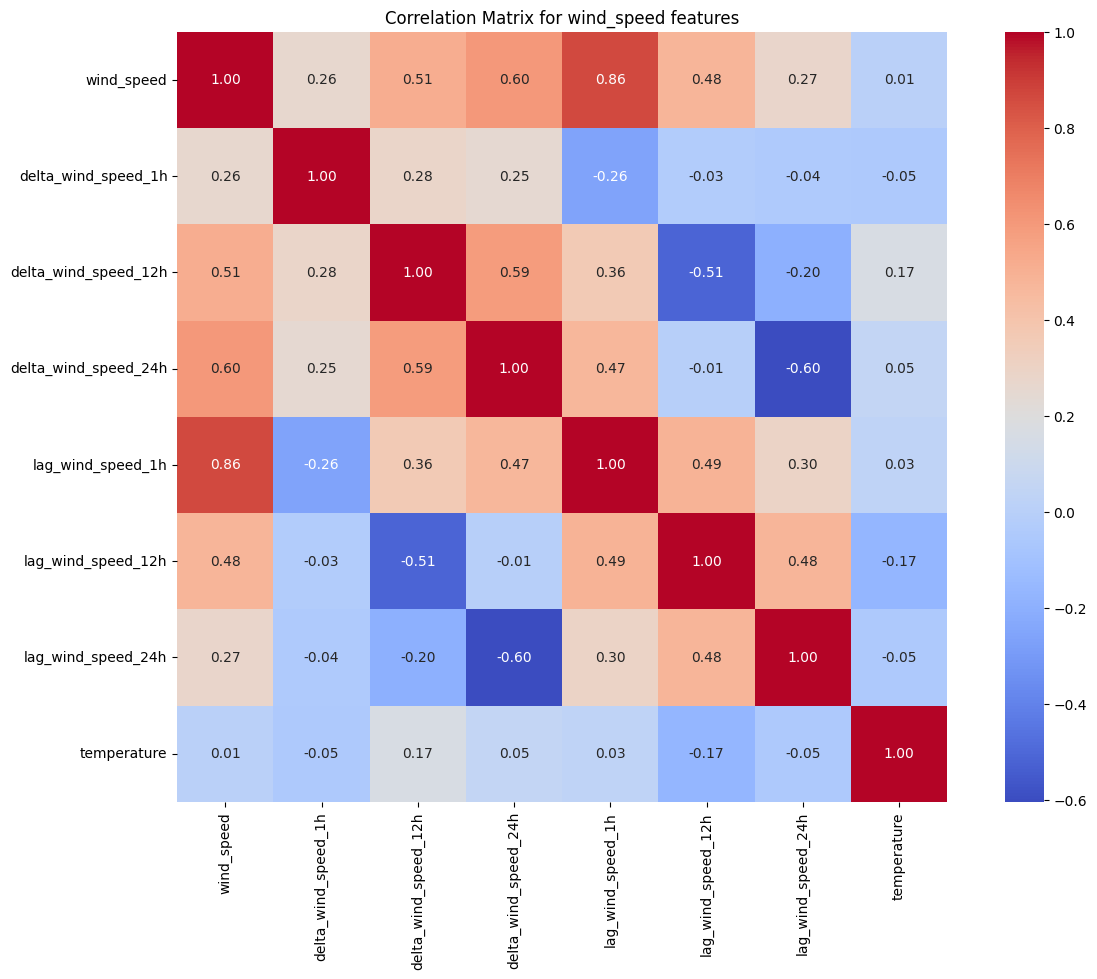

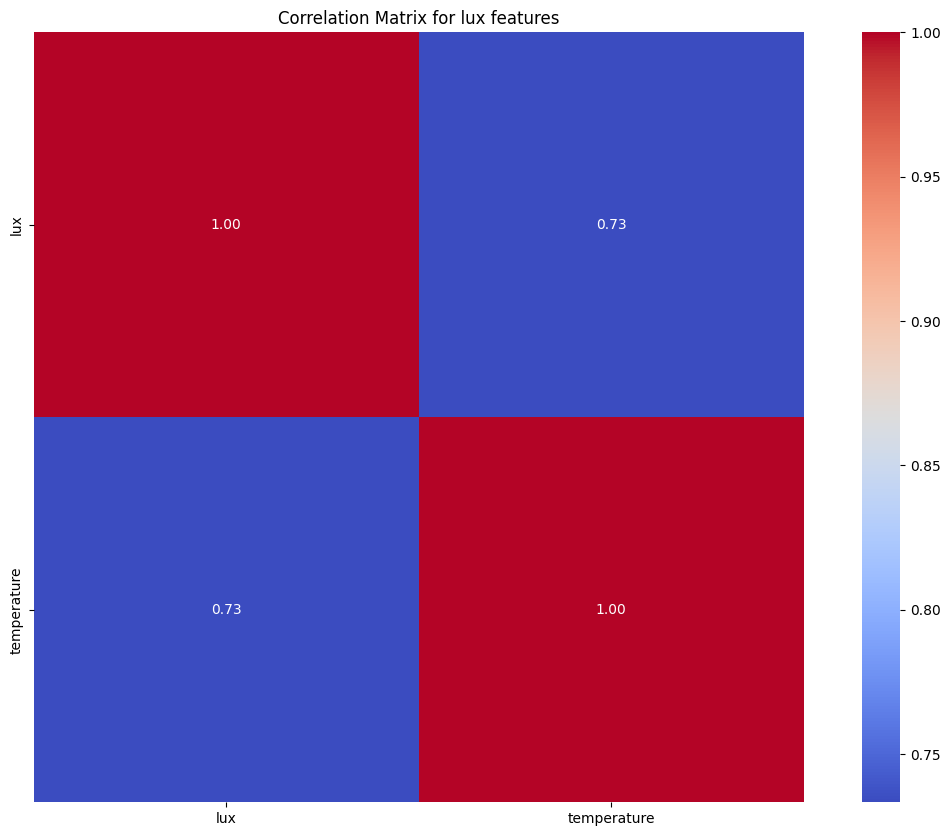

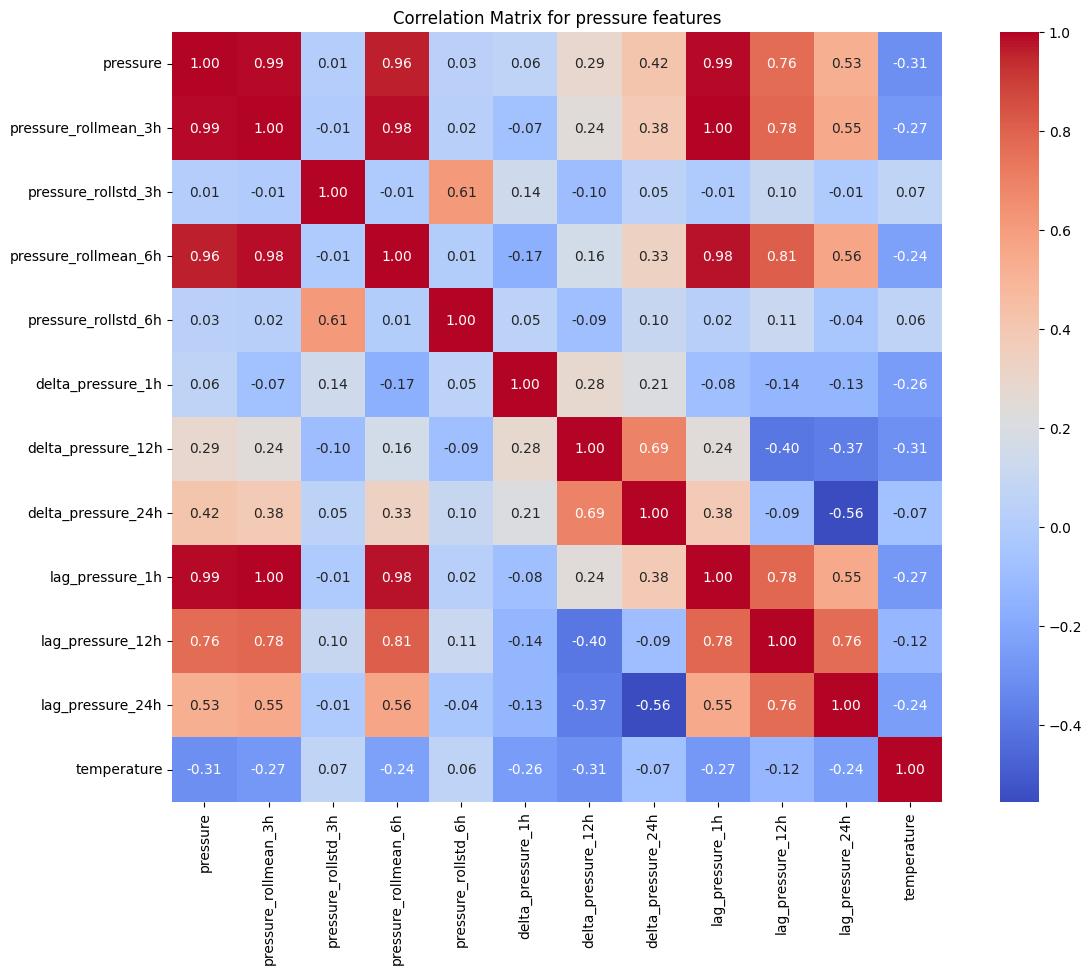

In [15]:
##Correlation analysis for humidity lag features

features = ["humidity","solar_radiation","wind_speed","lux","pressure"]

for i in features:
    columns = data[data.columns[data.columns.str.contains(i)]].columns.tolist()
    columns.append("temperature")
    corr_matrix = data[columns].corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Matrix for " + i + " features")
    plt.show()

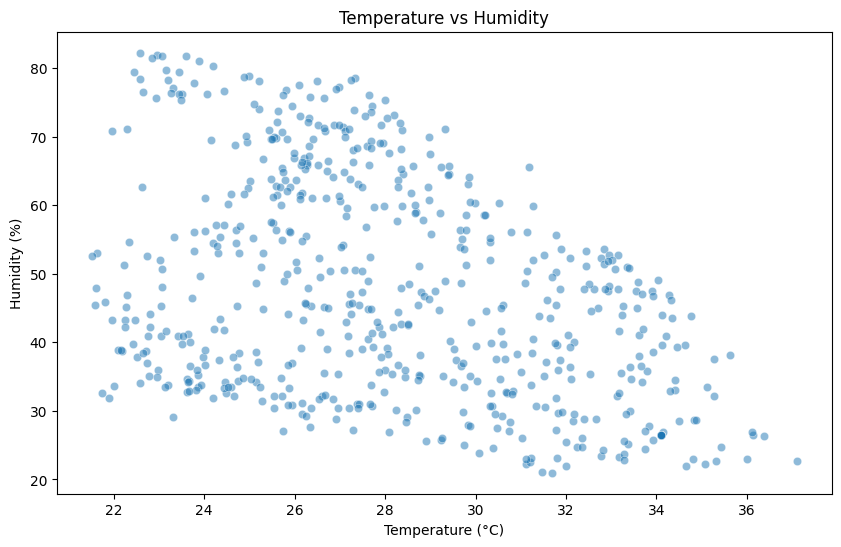

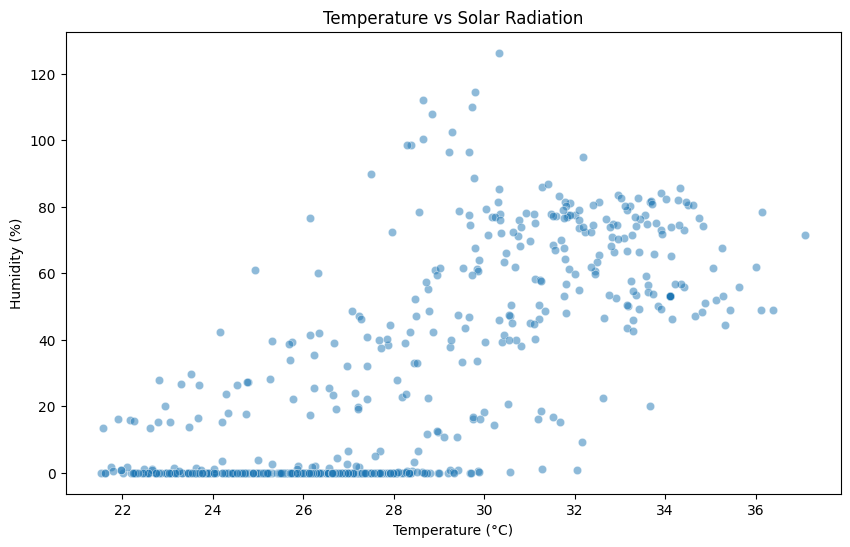

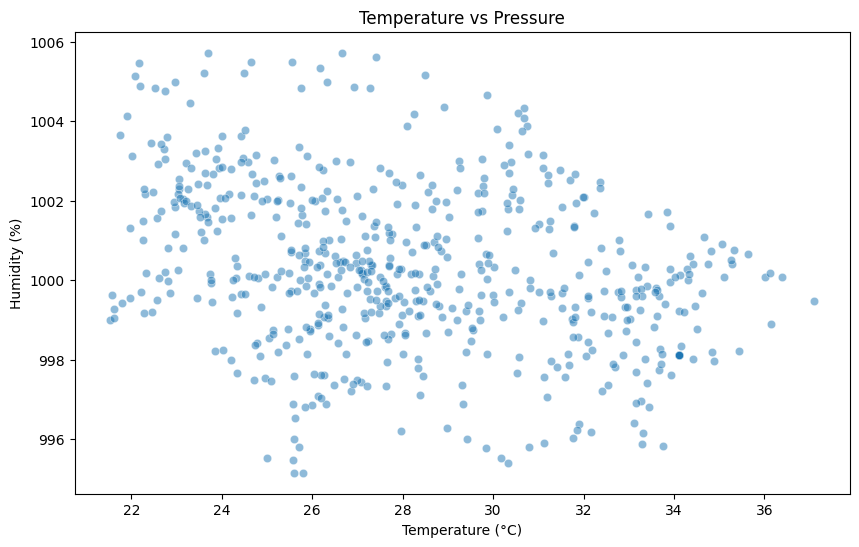

In [16]:
## Temperature and Humidity Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="humidity", alpha=0.5)
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

## Temperature and Humidity Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="solar_radiation", alpha=0.5)
plt.title("Temperature vs Solar Radiation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

## Temperature and Pressure Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="pressure", alpha=0.5)
plt.title("Temperature vs Pressure")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

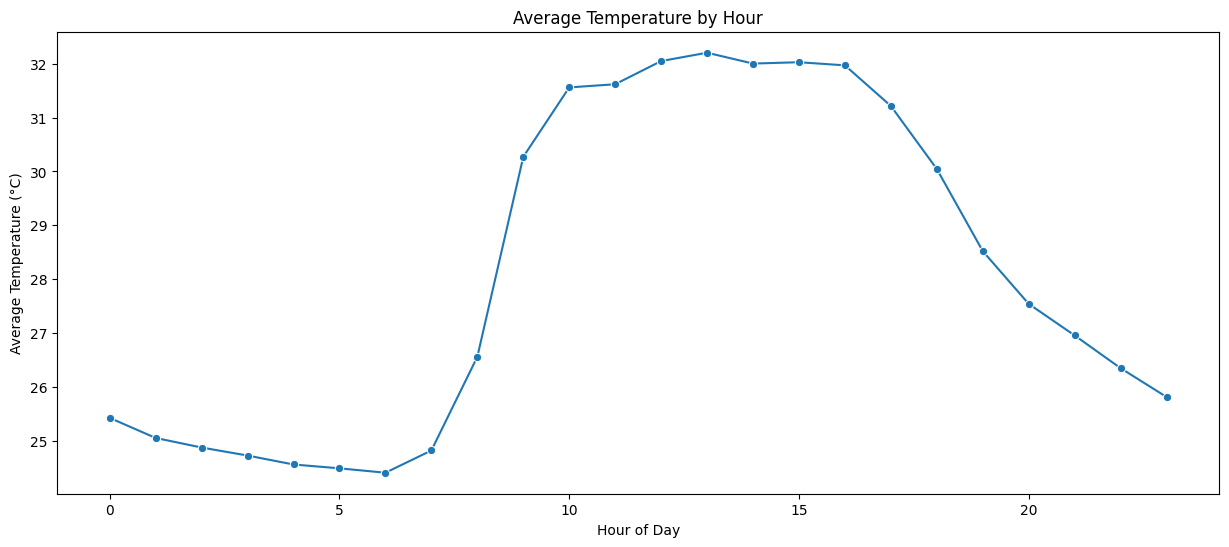

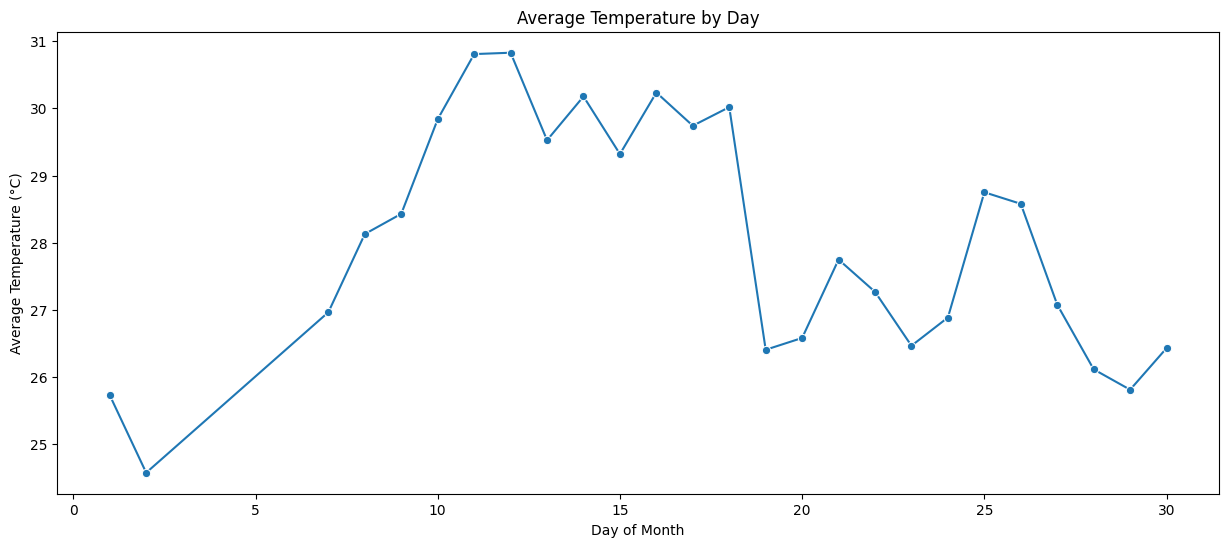

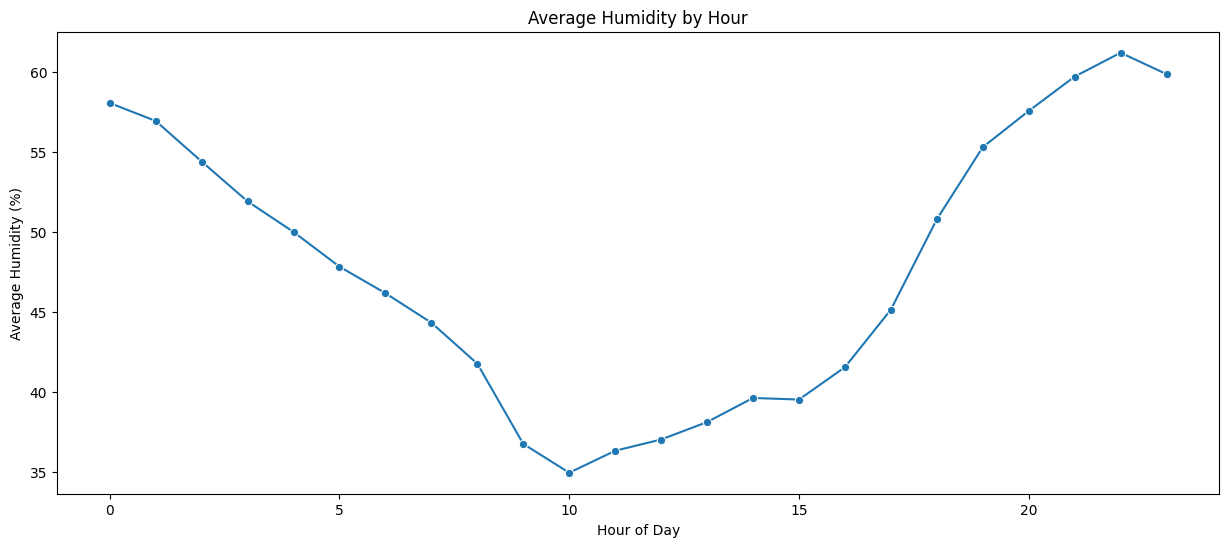

In [17]:
## Avg temperature by hour
avg_temp_by_hour = data.groupby('hour')['temperature'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_temp_by_hour, x='hour', y='temperature', marker='o')
plt.title("Average Temperature by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Temperature (°C)")
plt.show()

## Avg temperature by day
avg_temp_by_day = data.groupby('day')['temperature'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_temp_by_day, x='day', y='temperature', marker='o')
plt.title("Average Temperature by Day")
plt.xlabel("Day of Month")
plt.ylabel("Average Temperature (°C)")
plt.show()

##Avg humidity by hour
avg_humidity_by_hour = data.groupby('hour')['humidity'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_humidity_by_hour, x='hour', y='humidity', marker='o')
plt.title("Average Humidity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Humidity (%)")
plt.show()

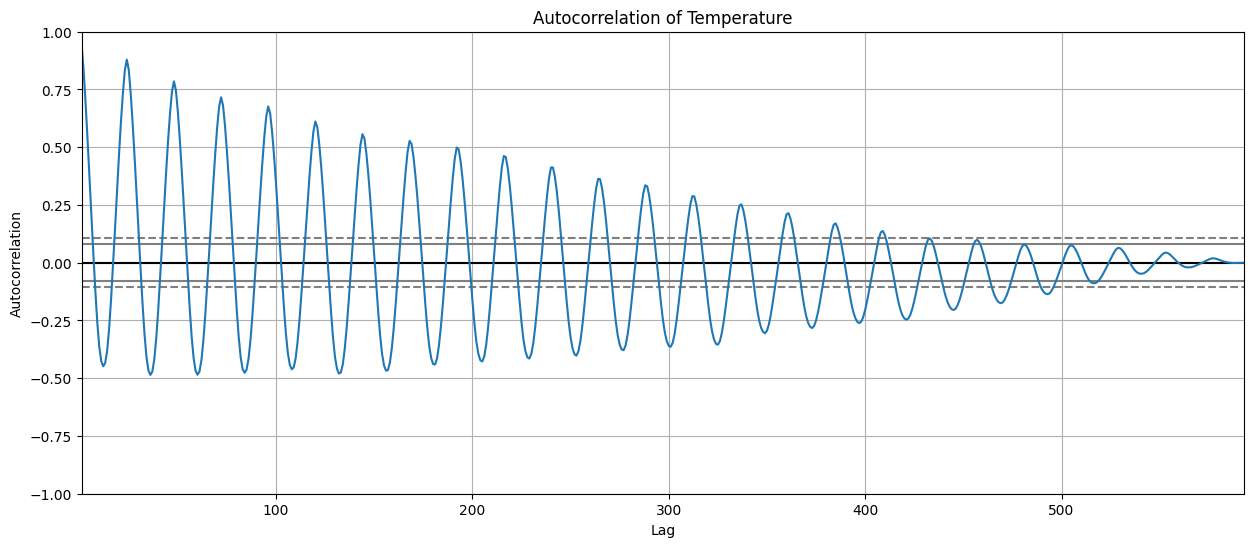

In [18]:
## Autocorrelation analysis
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15, 6))
autocorrelation_plot(data['temperature'])
plt.title("Autocorrelation of Temperature")
plt.show()

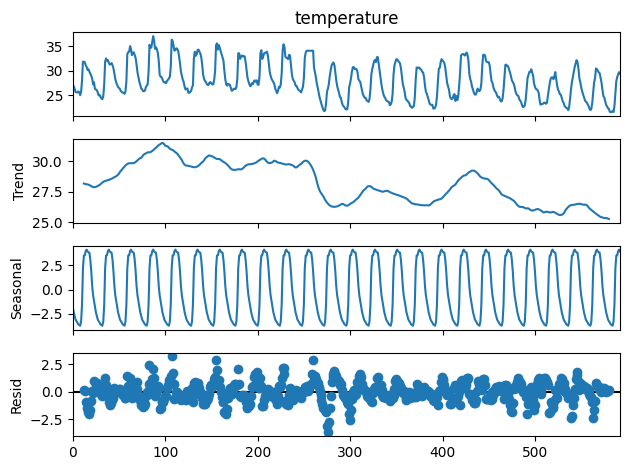

In [19]:
## time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['temperature'].dropna(), model='additive', period=24)
result.plot()
plt.show()